In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

sns.set_style('whitegrid')

# 1 Preprocessing

We want whole data to be in the format: movie_id,user_id,ratings,date

## 1.1 Loading data

In [2]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    data = open('data.csv',mode='w')
    
    row = list()
    # read all the files and store them in 'data.csv'
    files = ['combined_data_1.txt',
             'combined_data_2.txt',
            'combined_data_3.txt',
             'combined_data_4.txt']
    for file in files:
        print('Reading ratings from {}.....'.format(file))
        with open(file) as f:
            for line in f:
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':','')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0,movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print('Done.\n')
    data.close()
print('Time taken:',datetime.now() - start)

Time taken: 0:00:00


## 1.2 Creating Dataframe 'data.csv'

In [3]:
df = pd.read_csv('data.csv',sep=',',
                names=['movie_id','user_id','ratings','date'])

df.date = pd.to_datetime(df.date)

# Arranging ratings by time
df.sort_values(by='date',inplace=True)
df.head()

,movie_id,user_id,ratings,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


## 1.3 Desriptive Statistics of ratings

In [4]:
df.describe()['ratings']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

## 1.4 Checking null values

In [5]:
df.isnull().sum()

movie_id    0
user_id     0
ratings     0
date        0
dtype: int64

No null values present in the dataset

## 1.5 Checking Duplicates

In [6]:
dup_bool = df.duplicated(['movie_id','user_id','ratings'])
dups = sum(dup_bool)
print("Duplicate values present:", dups)

Duplicate values present: 0


## 1.6 Basic Statistics

In [7]:
print('Total number of ratings:',df.shape[0])
print('Total number of users:',len(np.unique(df.user_id)))
print('Total number of movies:',len(np.unique(df.movie_id)))

Total number of ratings: 100480507
Total number of users: 480189
Total number of movies: 17770


# 1.7 Splitting data into train and test dataset

we will not use train_test_split to split data because it is time series data, and we want to use old data to predict new data. If we split randomly, the accuracy of the data may now be true to real world scenerio.

In [8]:
if not os.path.isfile('train.csv'):
    # Top 80% of data is used for training
    df.iloc[:int(df.shape[0]*.80)].to_csv('train.csv',index=False)
    
if not os.path.isfile('test.csv'):
    # Remaining 20% of data is used for testing
    df.iloc[int(df.shape[0]*.80):].to_csv('test.csv',index=False)


train_df = pd.read_csv('train.csv',parse_dates=['date'])
test_df = pd.read_csv('test.csv')

### 1.7.1 Basic Statistics in Train data

In [9]:
print('Total number of ratings:',train_df.shape[0])
print('Total number of users:',len(np.unique(train_df.user_id)))
print('Total number of movies:',len(np.unique(train_df.movie_id)))

Total number of ratings: 80384405
Total number of users: 405041
Total number of movies: 17424


### 1.7.2 Basic Statistics in Test data

In [10]:
print('Total number of ratings:',test_df.shape[0])
print('Total number of users:',len(np.unique(test_df.user_id)))
print('Total number of movies:',len(np.unique(test_df.movie_id)))

Total number of ratings: 20096102
Total number of users: 349312
Total number of movies: 17757


Although the number of movies is more in test data but the ratings splits work. Hence, train has around 80% of data and test has the remaining 20%.

# 2 Exploratory Data Analysis

In [11]:
# Method to make y-axis more readable

def simple(num,units= 'M'):
    units = units.upper()
    num = float(num)
    if units == 'K':
        return str(num / 10 ** 3) + units
    elif units == 'M':
        return str(num / 10 ** 6) + units
    elif units == 'B':
        return str(num / 10 ** 9) + units

## 2.1 Distribution of ratings

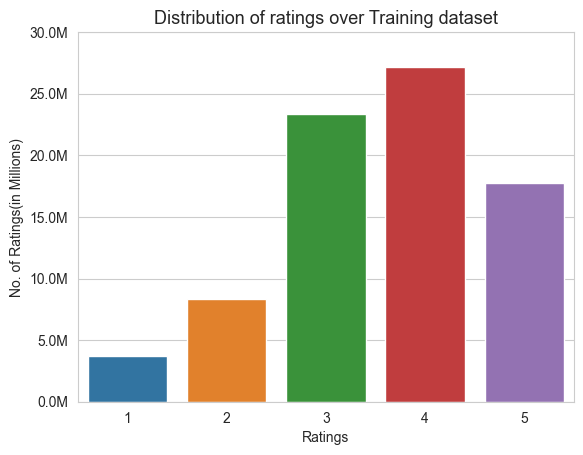

In [12]:
plt.title('Distribution of ratings over Training dataset', fontsize=13)
sns.countplot(x=train_df.ratings)
yticks = plt.yticks()
plt.yticks(ticks = yticks[0],labels=[simple(item)for item in yticks[0]],rotation='horizontal')
plt.xlabel('Ratings')
plt.ylabel('No. of Ratings(in Millions)')
plt.show()

**Insights:**

i) Most people give 4 star ratings.

ii) Very few people have 1 star rating.

iii) People give 5 stars rating more often than 1 star rating.

## 2.2 Adding Week day for analysis

In [13]:
train_df['day_of_week'] = train_df.date.dt.day_name()

train_df.tail()

,movie_id,user_id,ratings,date,day_of_week
80384400,12074,2033618,4,2005-08-08,Monday
80384401,862,1797061,3,2005-08-08,Monday
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


## 2.3 Number of Ratings per month

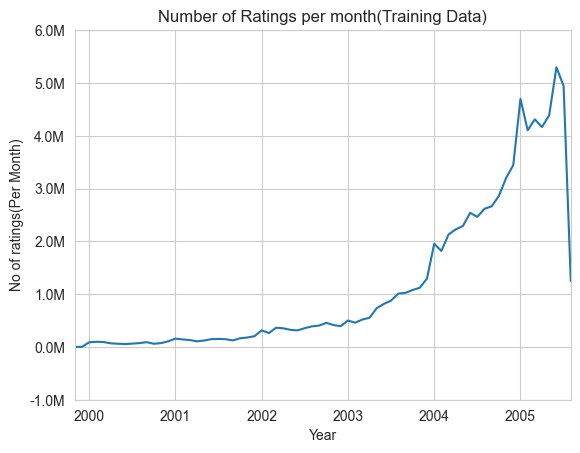

In [14]:
train_df.resample('m',on='date')['ratings'].count().plot()
yticks = plt.yticks()
plt.yticks(ticks = yticks[0],labels=[simple(item)for item in yticks[0]],rotation='horizontal')
plt.title('Number of Ratings per month(Training Data)')
plt.ylabel('No of ratings(Per Month)')
plt.xlabel('Year')
plt.show()

**Insights:**

i) There is a sudden rise of ratings from 2003 to 2005. It shows Netlfix might have grew as a company during that period.

## 2.4 Analysis on the ratings

### 2.4.1 Number of movies rated per user

In [15]:
no_of_movies_rated_per_user = train_df.groupby(by='user_id')['ratings'].count()
no_of_movies_rated_per_user.sort_values(ascending=False).head()

user_id
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: ratings, dtype: int64

**Insights:**

i) User 305344 rated most number of movies.

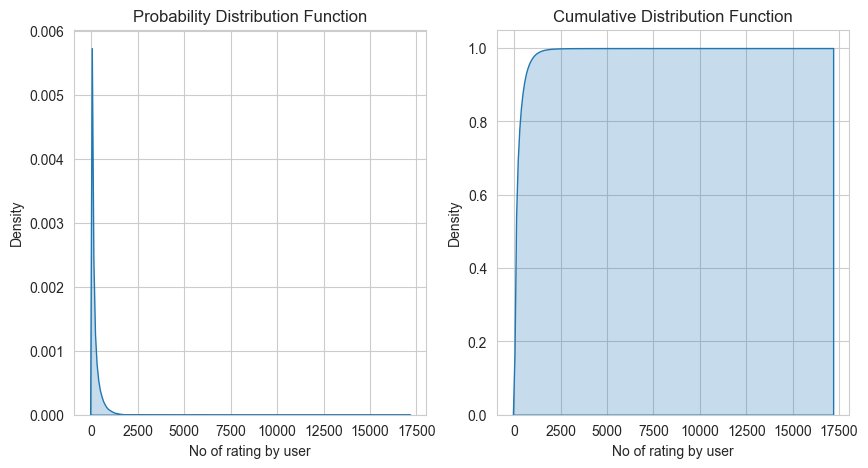

In [16]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
sns.kdeplot(no_of_movies_rated_per_user, fill=True,ax=ax1)
plt.xlabel('No of rating by user')
plt.title('Probability Distribution Function')

ax2 = plt.subplot(122)
sns.kdeplot(no_of_movies_rated_per_user,fill=True,cumulative=True,ax=ax2)
plt.xlabel('No of rating by user')
plt.title('Cumulative Distribution Function')

plt.show()

**Insights:**

i) Most users give few ratings while only a small portion have more ratings.

In [17]:
no_of_movies_rated_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: ratings, dtype: float64

**Insights:**

i) Average number of movies rated by a user is 198.

ii) Half of the users rate 89 or more movies.

iii) Three-fourth of the users have rated movies less than 245.

iv) Minimum number of movie rated is 1.

v) Maximum number movies rated are 17112.

#### 2.4.1.1 Plotting Quantiles

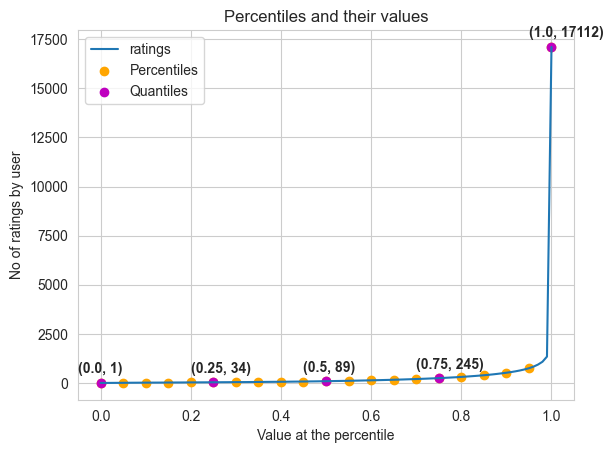

In [18]:
percentiles = no_of_movies_rated_per_user.quantile(np.arange(0,1.01,0.01),interpolation='nearest')

plt.title('Percentiles and their values')
percentiles.plot()
plt.scatter(x=percentiles.index[::5], y = percentiles.values[::5], c = 'orange', label='Percentiles')
plt.scatter(x=percentiles.index[::25], y= percentiles.values[::25],c='m',label='Quantiles')
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the percentile')
plt.legend(loc='best')

for x,y in zip(percentiles.index[::25],percentiles[::25]):
    plt.annotate(text="({}, {})".format(x,y), xy = (x,y), xytext=(x-0.05,y+500),fontweight='bold')
    
plt.show()

In [19]:
print('95th Percentile:',percentiles.iloc[95])
print('100th Percentile:', percentiles.iloc[100])

95th Percentile: 749
100th Percentile: 17112


**Insights:**

i) 95% of users have rated less than 749 movies.

ii) Only 5% of user have rated movies more than 749.

### 2.4.2 Number of rating per movie

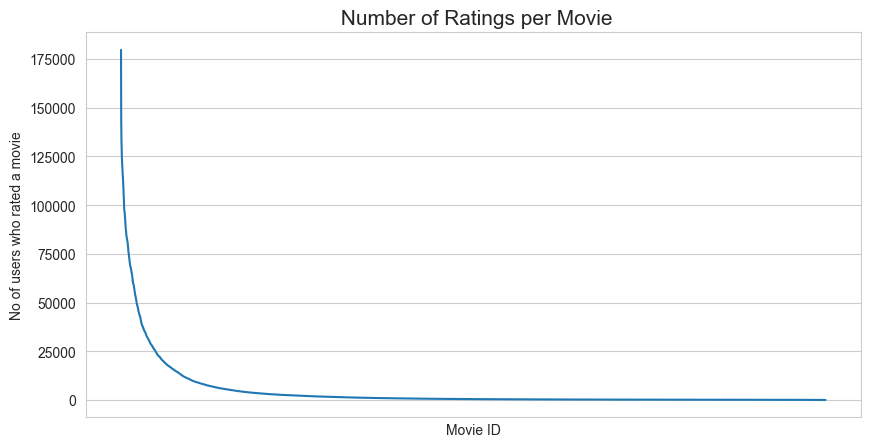

In [20]:
no_of_ratings_per_movie = train_df.groupby(by='movie_id')['ratings'].count().sort_values(ascending=False)

plt.figure(figsize=(10,5))
plt.plot(no_of_ratings_per_movie.values)
plt.title(' Number of Ratings per Movie',fontsize=15)
plt.xlabel('Movie ID')
plt.ylabel('No of users who rated a movie')
plt.xticks([])
plt.show()

**Insights:**

i) The graph is highly skewed. It suggest that there are few movies rated by many users. This could be popular movies like 'Pirates Of The Carribean'.

ii) But most of the movies were rated by a small number of users.

### 2.4.3 Number of ratings on each day of the week 

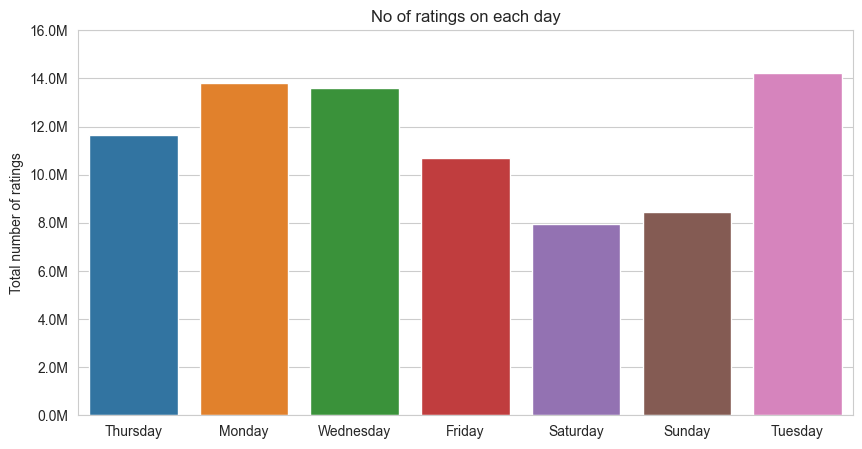

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(x='day_of_week',data=train_df)
plt.title('No of ratings on each day')
plt.ylabel('Total number of ratings')
plt.xlabel('')
plt.yticks(ticks=plt.yticks()[0], labels = [simple(item) for item in plt.yticks()[0]])
plt.show()

**Insights:**

i) *Tuesdays* have the highest number of movies rated, followed by *Monday* and *Wednesday*.

ii) Suprisingly, weekends have the least number of movies rated.

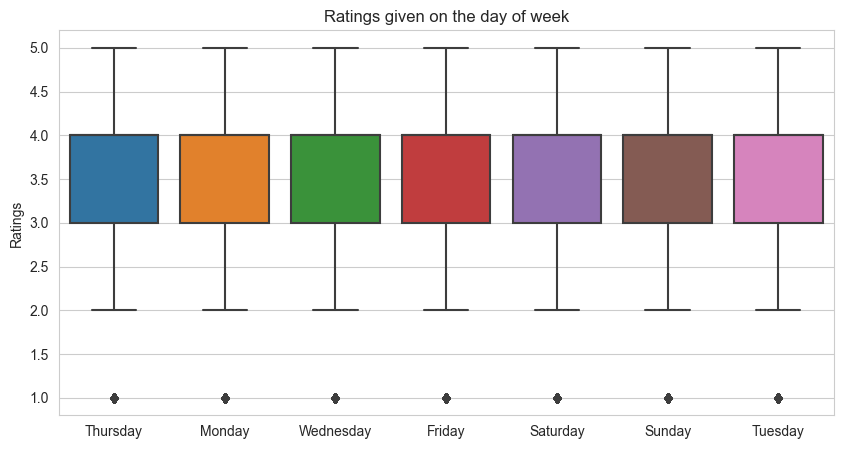

In [22]:
plt.figure(figsize=(10,5))
plt.title('Ratings given on the day of week')
sns.boxplot(y='ratings', x='day_of_week', data=train_df)
plt.ylabel('Ratings')
plt.xlabel('')
plt.show()

**Insights:**

i) All the boxplots are similar. It means the ratings given does not depend much on day of the week.

In [23]:
avg_week_df = train_df.groupby(['day_of_week'])['ratings'].mean()
print('Average Ratings on a Day of the Week')
print('-'*30)
print(avg_week_df)

Average Ratings on a Day of the Week
------------------------------
day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: ratings, dtype: float64


**Insights:**

i) This proves day of the week does not tell much about ratings.

## 2.5 Creating Sparse Matirx

Sparse matrix is used in recommendation system. For the given dataframe, the row would contain all the users and the columns all the movies. Each field ***i,j*** would contain the ratings given by the ***user i*** to ***movie j***.

### 2.5.1 Train Dataframe

In [24]:
start = datetime.now()

if os.path.isfile('train_sparse_matrix.npz'):
    # It is already present in the device
    print('Loading from the disk......')
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print('Done.')
else:
    # Creating sparse matrix
    print('Creating Sparse Matrix....')
    train_sparse_matrix = csr_matrix((train_df.ratings.values,(train_df.user_id.values,train_df.movie_id.values)))
    print('Done.')
    print('Shape of the matrix:', train_sparse_matrix.shape)
    # Saving it to drive for future use
    print('Saving to the disk......')
    sparse.save_npz('train_sparse_matrix.npz',train_sparse_matrix)
    print('Done.')
    
print(datetime.now() - start)

Loading from the disk......
Done.
0:00:02.818263


In [25]:
row, col = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print('Sparsity of Train matrix: {}% '.format((1-(elem/(row*col)))*100))

Sparsity of Train matrix: 99.8292709259195% 


### 2.5.2 Test Dataframe

In [26]:
start = datetime.now()

if os.path.isfile('test_sparse_matrix.npz'):
    # It is already present in the device
    print('Loading from the disk......')
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print('Done.')
else:
    # Creating sparse matrix
    print('Creating Sparse Matrix....')
    test_sparse_matrix = csr_matrix((test_df.ratings.values,(test_df.user_id.values,test_df.movie_id.values)))
    print('Done.')
    print('Shape of the matrix:', test_sparse_matrix.shape)
    # Saving it to drive for future use
    print('Saving to the disk......')
    sparse.save_npz('test_sparse_matrix.npz',test_sparse_matrix)
    print('Done.')
    
print(datetime.now() - start)

Loading from the disk......
Done.
0:00:00.741499


In [27]:
row, col = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print('Sparsity of Train matrix: {}% '.format((1-(elem/(row*col)))*100))

Sparsity of Train matrix: 99.95731772988694% 


## 2.6 Calculating Global Average ratings, Average ratings per user, and Average ratings per movie

In [28]:
def get_avg_ratings(sparse_matrix,of_users):
    axis = 1 if of_users else 0  # 1- user axis ; 0- movie axis
    
    sum_of_ratings = sparse_matrix.sum(axis=axis).A1 # A1 converts matrix to 1-D array
    is_rated = sparse_matrix != 0 # True if a movie is rated False if not
    
    # No of ratings for each user/movie
    no_of_ratings = is_rated.sum(axis=axis).A1
    
    # total_user and total_movie ids in sparse matrix
    u,m = sparse_matrix.shape
    
    # create a dictionary of users/movies and their average ratings
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i]
                      for i in range(u if of_users else m)
                      if no_of_ratings[i] != 0}
    
    # return the dictionary
    return average_ratings

In [29]:
train_averages = {}

# Global average ratings
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
print('Average Ratings: ',train_global_average)

# Average ratings per user
train_averages['user'] = get_avg_ratings(train_sparse_matrix,of_users=True)
print('Average rating of user ID 59: ', train_averages['user'][59])

# Average ratings per movies
train_averages['movie'] = get_avg_ratings(train_sparse_matrix,of_users=False)
print('Average rating of movie ID 253: ', train_averages['movie'][253])

Average Ratings:  3.582890686321557
Average rating of user ID 59:  3.698717948717949
Average rating of movie ID 253:  4.0723557028445185


### 2.6.3 PDFs and CDFs

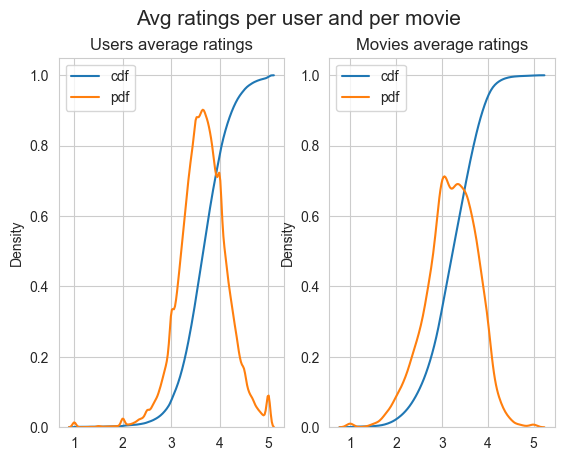

In [30]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.suptitle('Avg ratings per user and per movie', fontsize=15)

ax1.set_title('Users average ratings')
user_averages = [rat for rat in train_averages['user'].values()]
sns.kdeplot(user_averages,ax=ax1,cumulative=True,label='cdf')
sns.kdeplot(user_averages,ax=ax1,label='pdf')
ax1.legend()

ax2.set_title('Movies average ratings')
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.kdeplot(movie_averages,ax=ax2,cumulative=True,label='cdf')
sns.kdeplot(movie_averages,ax=ax2,label='pdf')
ax2.legend()

plt.show()

## 2.7 Cold Start problem

Since the data given is time series data, and we have split it into test and train based on the time, there could be some users who are only present in test dataset(like users who recently joined Netflix) and some movies which are only available in test dataset(new released movies). This is cold start problem.

### 2.7.1 With Users

In [31]:
total_users = len(np.unique(df.user_id))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('Total Users: ', total_users)
print('Users in train data: ', users_train)
print('Users not present in train data: {}({}%)'.format(new_users,round((new_users/total_users)*100,2)))

Total Users:  480189
Users in train data:  405041
Users not present in train data: 75148(15.65%)


### 2.7.2 With Movies

In [32]:
total_movies = len(np.unique(df.movie_id))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('Total Users: ', total_movies)
print('Users in train data: ', movies_train)
print('Users not present in train data: {}({}%)'.format(new_movies,round((new_movies/total_movies)*100,2)))

Total Users:  17770
Users in train data:  17424
Users not present in train data: 346(1.95%)


**Insight:**  

i)There are 15.65% of new users in test data.

ii) Around 1.95% of movies are not present in train data.

iii) Cold start problem is not so severe in case of movies but it is in case of users.

# 3 Similarity Matrix

Computing cosine similarity of user-user would take very much time since the data is more with more columns. On the other hand, movie-movie similarity would take comparitvely less time to compute since the data is less and most of the fields are sparse. Also, we want to predict similar movies, therefore it is important to compute movie-movie similarity.

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    # If the file is not present in the drive
    print('Computing Similarity Matrix......')
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T,dense_output=False)
    print('Saving it to the disk.......')
    sparse.save_npz('m_m_sim_sparse.npz',m_m_sim_sparse)
    print('Done.')

else:
    # If the file is already present in the device
    print('Loading file from the disk....')
    m_m_sim_sparse = sparse.load_npz('m_m_sim_sparse.npz')
    print('Done.')
print('\n\n\n')
print('Dimensions of the matrix: ', m_m_sim_sparse.shape)
print('Time taken to compute/load: ', datetime.now() - start)

Loading file from the disk....


MemoryError: Unable to allocate 2.23 GiB for an array with shape (299544666,) and data type float64

We don't care about all the movies. We only want movies with most similarity.

In [34]:
# Creating a dictionary of top similar movies
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1]).astype('floa')

similar_movies = dict()
for movie in movie_ids:
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]

MemoryError: Unable to allocate 1.12 GiB for an array with shape (299544666,) and data type int32

## 3.1 Finding Most Similar movies using Similarity Matrix

In [36]:
movie_titles = pd.read_csv('movie_titles.csv',sep=r'^([^,]+),([^,]+),',names=['movie_id','year_of_release','title'],engine='python',index_col=0,
                           header=None,encoding = "ISO-8859-1")
movie_titles.set_index('movie_id',inplace=True)
movie_titles.head()

,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [37]:
mv_id = int(input('Enter a movie id(any number from 1 to 17770):'))

si = similar_movies[mv_id]
print('\n\n')
print('Movie Name: ',movie_titles.loc[mv_id].values[1])
print('\nMovies you might like:')
movie_titles.loc[si[:10]]

Enter a movie id(any number from 1 to 17770): 67


NameError: name 'similar_movies' is not defined

# 4 Feature Engineering

since the train data and test data is already very large and it would take a lot of time to train model on them, we will sample them again to smaller dataframe.

In [38]:
def get_sample_sparse_matrix(sparse_matrix,path,num_users,num_movies):
    """Samples sparse matrix randomly into the smaller sparse matrix"""

    # get row,column and ratings tuple from sparse matrix
    row_idx, col_idx,ratings = sparse.find(sparse_matrix)
    users = np.unique(row_idx)
    movies = np.unique(col_idx)

    # random sampling users and movies
    np.random.seed(42)
    sample_users = np.random.choice(users,num_users,replace=False)
    sample_movies = np.random.choice(movies,num_movies,replace=False)

    # Masking whether the sample_user and sample_movies are present in the original sparse matrix
    # logical and returns true only if both the conditions are satisfied.
    
    mask = np.logical_and(np.isin(row_idx,sample_users),
                          np.isin(col_idx,sample_movies))

    sample_sparse_matrix = csr_matrix((ratings[mask],(row_idx[mask],col_idx[mask])),
                                      shape=(max(sample_users)+1,max(sample_movies)+1))

    sparse.save_npz(path,sample_sparse_matrix)

    return sampled_sparse_matrix

In [39]:
# Sampling train_sparse_matrix
start = datetime.now()
path = 'sample_train_sparse_matrix.npz'
if os.path.isfile(path):
    print('Already present in the disk. Loading....')
    sample_train_sparse_matrix = sparse.load_npz(path)
    print('Done.')
else:
    print('Creating sample sparse matrix.....')
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix,path,num_users=20000,num_movies=2000)
    print('Done.')

print('Time Taken: ', datetime.now()-start)

Creating sample sparse matrix.....


MemoryError: Unable to allocate 613. MiB for an array with shape (80384405,) and data type int64

In [ ]:
# Sampling test_sparse_matrix
start = datetime.now()
path = 'sample_test_sparse_matrix.npz'
if os.path.isfile(path):
    print('Already present in the disk. Loading....')
    sample_test_sparse_matrix = sparse.load_npz(path)
    print('Done.')
else:
    print('Creating sample sparse matrix.....')
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix,path=path,num_user=10000,num_movies=1000)
    print('Done.')

print('Time Taken: ', datetime.now()-start)

## 4.1 Feature Transformation for Regression

**Features to be created:**

* **GAvg** : Global average rating.
* **UAvg** : User's average rating.
* **MAvg** : Movie's average rating.
* **Similar users rating of this movie** :
  * Top 5 similar users who rated that movie. Null values are discarded.
  * features: sur1,sur2, sur3,sur4,sur5.
* **Similar movies rated by this user** :
  * Top 5 similar movies rated by this user. Null values are discarded.
  * features: smr1,smr2, smr3,smr4,smr5
* **ratings** : rating of this movie by this user.

### 4.1.1 Sampled train data

In [ ]:
# Calculating global, per user, and per movies average ratings
sample_train_averages = {}
global_avg = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_avg
sample_train_averages['user'] = get_avg_ratings(sample_train_sparse_matrix,of_users=True)
sample_train_averages['movie'] = get_avg_rating(sample_train_sparse_matrix,of_users=False)


In [ ]:
# Creating above features for regression
sample_train_users,sample_train_movies,sample_train_ratings = sparse.find(sample_train_matrix)

start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print('File already exist.')
else:
    with open('reg_train.csv',mode='w') as reg_data_file:
        count = 0
        for (user,movie,rating) in zip(sample_train_users,sample_train_movies,sample_train_ratings):
            st = datetime.now()
            # --- Ratings of "movie" by similar users of "user" ---
            # Compute top similar users of the current user
            user_sim = cosine_similarity(sample_train_sparse_matrix[user],sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # index from 1 to remove current user from similar users
            top_ratings = sample_train_sparse_matrix[top_sim_users,movie].toarray().ravel()

            # Taking only non-zero values
            top_sim_user_ratings = list(top_ratings[top_ratings != 0][:5])
            
            # Just in case current user doesn't have 5 similar movies, we'll use the average for remaining
            top_sim_user_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_user_ratings)))


            # --- Ratings of "user" to similar movies of "movie" ---
            top_sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
            top_ratings = sample_train_sparse_matrix[user,top_sim_movies].toarray().ravel()

            # Taking only non-zero values
            top_sim_movie_ratings = list(top_ratings[top_ratings != 0])

            # Just in case current movie doesn't have 5 similar users, we'll use the average for remaining.
            top_sim_movie_ratings.extend([sample_train_averages['user'][user]*(5-len(top_sim_movie_ratings)))

            # --- Adding all this into a single row ---
            row = list()
            row.append(user) # User_id
            row.append(movie) #Movie_id
            row.append(sample_trainings_averages['global']) #GAvg
            
            # "movie" ratings for similar_users
            row.extend(top_sim_user_ratings)
            
            # "user" ratings for similar_movies
            row.extend(top_sim_movie_ratings)

            row.append(sample_train_averages['user'][user]) #UAvg
            row.append(sample_train_averages['movie'][movie]) #MAvg
            row.append(rating) #rating

            count +=1

            # --- Add rows to the file ---
            reg_data_file.write(','.join(map(str,row)))
            reg_data_file.write('\n')

            if (count % 10000) == 0:
                print("Done for {} rows. Time taken: {}".format(count,datetime.now()-st))

print('\n\n Total time taken: ', datetime.now()- start)

                    

In [ ]:
reg_train = pd.read_csv('reg_train.csv', names = ['user','movie','GAvg','sur1','sur2','sur3','sur4',
                                                  'sur5','smr1','smr2','smr3','smr4','smr5','UAvg','MAvg',
                                                  'rating'],header=None)
reg_train.head()

### 4.1.2 Sampled test data

In [ ]:
sample_test_users, sample_test_movies,sample_test_ratings = sparse.find(sample_test_spares_matrix)

start = datetime.now()

if os.path.isfile('reg_test.csv'):
    print('File already exist.')
else:
    with open('reg_test.csv',mode='w') as reg_data_file:
        count = 0
        for (user,movie,rating) in zip(sample_test_users,sample_test_movies,sample_test_ratings):
            st = datetime.now()

            # --- Ratings of "movie" by similar users of "user"
            try:
                # We will use train sparse matrix only for test data
                user_sim = cosine_similarity(sample_train_sparse[user],sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:]
                top_ratings = sample_train_sparse_matrix[top_sim_users,movie].toarray().ravel()

                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages[['movie'][movie]]*(5-len(top_sim_users_ratings)))
            except (IndexError, KeyError):
                # It is a new user, so we don't have any similar ratings,i.e., cold start problem
                # We will solve this using averages
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_users_ratings)))
            except:
                print(user,movie)
                raise


            # --- Ratings of "user" by similar movies of "movie" 
            try:
                top_sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
                top_ratings = sample_train_matrix[user,top_sim_movies].toarray().ravel()
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))
            except (IndexError,KeyError):
                # New movie(Cold Start Problem)
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim)movies_ratings)))
            except:
                raise


            # --- Adding all this to a single row ---
            row = list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global'])
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise

            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])

            row.append(rating)
            count += 1

            reg_data_file.write(','.join(map(str,row)))
            reg_data_file.wrtie('\n')

            if (count % 1000 == 0):
                print("Done for {} rows. Time taken: {}".format(count,datetime.now()-st))

print('\n\n Total time taken: ', datetime.now() - start)

In [ ]:
reg_test_df = pd.read_csv('reg_test.csv',names=['user','movie','GAvg','sur1','sur2','sur3',
                                                'sur4','sur5','smr1','smr2','smr3','smr4','smr5',
                                                'UAvg','MAvg','rating'],header=None)
reg_test_df.head()

**My laptop keep crashing whenever I try to do anything more. Turns out either my latop or I lack comprehension capabilities to go beyond this point. I will come back to this project as soon as I get the answer to the questions why it was happening.**